# Лабораторная 2. Интерпретация моделей

ФИО: Фам Данг Чунг Нгиа

Группа: P3321

ISU: 374806

## Преобработка данных

### Загрузка данных

Датасет обрабатыванный из первой лабораторной

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# read dataset
df = pd.read_csv("walmart_prepared_lab1.csv")
df.head(), df.shape

(   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
 0      1  2011-02-04    1606629.58             0     0.375877    0.010040   
 1      1  2011-02-11    1649614.93             1     0.312385    0.032129   
 2      1  2011-02-18    1686842.78             0     0.538819    0.047523   
 3      1  2011-02-25    1456800.28             0     0.598639    0.060910   
 4      1  2011-03-04    1636263.41             0     0.562790    0.210174   
 
         CPI  Unemployment  Year  Month  ...  IsQuarterEnd  Season  \
 0  0.852623      0.542239  2011      2  ...             0       1   
 1  0.856340      0.542239  2011      2  ...             0       1   
 2  0.859467      0.542239  2011      2  ...             0       1   
 3  0.862358      0.542239  2011      2  ...             0       1   
 4  0.865249      0.542239  2011      3  ...             0       1   
 
    Weekly_Sales_lag1  Weekly_Sales_lag2  Weekly_Sales_lag4  \
 0           0.318269           0.321305     

### Выбрать target, features; Split train/test

In [ ]:
target_col = "Weekly_Sales"

# Drop unnecessary columns
drop_cols = [target_col, "Date"]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train.shape, X_test.shape


((2972, 25), (744, 25))

## Обучить модели xgboost, random forest

### Train RandomForest + reviews

In [ ]:
# ---- Random Forest ----
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,  # defaut bootstrap = true -> bagging ; max_feature -> random subspace
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

def regression_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

metrics_rf = regression_metrics(y_test, y_pred_rf)
metrics_rf

{'MAE': 38074.25296335124,
 'MSE': 3730518633.8071027,
 'RMSE': np.float64(61077.971755839295),
 'R2': 0.988899050301226}

* MAE ≈ 38 074 и RMSE ≈ 61 078. Это получилось при больших значениях недельных продаж.

* R² ≈ 0.989 поквзывает, что модель объясняет около 98.9% варианта недельных продаж, т.е. даёт очень хорошее приближение зависимости недельных продаж от признаков

### Train XGBoost + reviews

In [ ]:
# ---- XGBoost ----
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

metrics_xgb = regression_metrics(y_test, y_pred_xgb)
metrics_xgb


{'MAE': 29561.404858870963,
 'MSE': 1984759509.3375926,
 'RMSE': np.float64(44550.6398308441),
 'R2': 0.9940939269736779}

### Metrics comperasion

In [ ]:
pd.DataFrame({"RandomForest": metrics_rf, "XGBoost": metrics_xgb})


,RandomForest,XGBoost
MAE,3.807425e+04,2.956140e+04
MSE,3.730519e+09,1.984760e+09
RMSE,6.107797e+04,4.455064e+04
R2,9.888991e-01,9.940939e-01



1. **Обе модели работают очень хорошо.**

   Значения R² ≈ 0.99 означают, что модели объясняют около **99% вариации Weekly_Sales** на тестовой выборке. Значения RMSE порядка 4–6×10⁴ выглядят разумно, если недельные продажи измеряются десятками–сотнями тысяч.

2. **XGBoost лучше, чем Random Forest.**

   У XGBoost **MAE, MSE и RMSE ниже**, а **R² выше**, чем у Random Forest. Это логично, так как XGBoost, как правило, лучше использует сложные признаки (лаги, скользящие и накопленные средние и т.п.).

3. **Практический смысл.**

   Средняя абсолютная ошибка XGBoost составляет около **30 тысяч денежных единиц** в неделю. Для больших объёмов продаж это приемлемый уровень ошибки для модели без глубокой настройки гиперпараметров.

Итого: **XGBoost целесообразно выбрать как основную модель для анализа важности признаков и SHAP**, а Random Forest использовать как модель для сравнения.


## Feature importance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure we have feature names from X
feature_names = X_train.columns

# --- Random Forest feature importance ---
rf_importances = rf.feature_importances_
rf_fi = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
})
rf_fi = rf_fi.sort_values("importance", ascending=False).reset_index(drop=True)

print("Random Forest feature importance (top 10):")
print(rf_fi.head(10))


# --- XGBoost feature importance ---
xgb_importances = xgb.feature_importances_
xgb_fi = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_importances
})
xgb_fi = xgb_fi.sort_values("importance", ascending=False).reset_index(drop=True)

print("\nXGBoost feature importance (top 10):")
print(xgb_fi.head(10))


Random Forest feature importance (top 10):
                feature  importance
0         WS_roll4_mean    0.376493
1        Store_cum_mean    0.320447
2  Store_Week_hist_mean    0.145824
3    Weekly_Sales_lag52    0.130748
4     Weekly_Sales_lag1    0.014522
5          Unemployment    0.002196
6     Weekly_Sales_lag4    0.001756
7     Weekly_Sales_lag2    0.001424
8                   CPI    0.000937
9            Fuel_Price    0.000865

XGBoost feature importance (top 10):
                feature  importance
0        Store_cum_mean    0.360924
1         WS_roll4_mean    0.306938
2  Store_Week_hist_mean    0.217585
3    Weekly_Sales_lag52    0.078567
4     Weekly_Sales_lag1    0.013856
5        IsQuarterStart    0.003707
6          Holiday_Flag    0.002019
7     Weekly_Sales_lag2    0.001952
8          IsMonthStart    0.001823
9          Unemployment    0.001751


* Store_cum_mean, WS_roll4_mean, Store_Week_hist_mean, Weekly_Sales_lag52
→ эти признаки самые важные. Модель сильно на них опирается, они важны для прогноза.

* Unemployment, CPI, Fuel_Price, Holiday_Flag, IsMonthStart, IsQuarterStart
→ почти не влияют. Их важность очень маленькая. Можно обучить модель без них и посмотреть, сильно ли упадёт качество.


Графики показывают результат

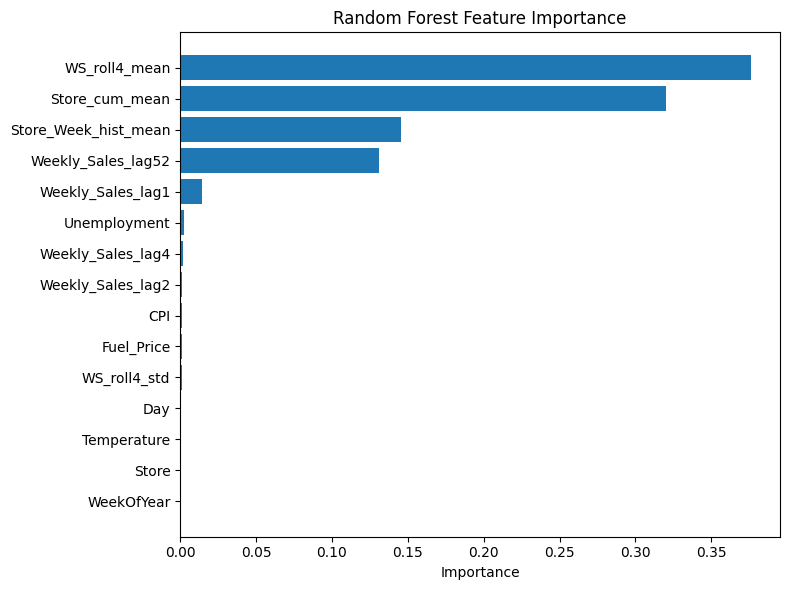

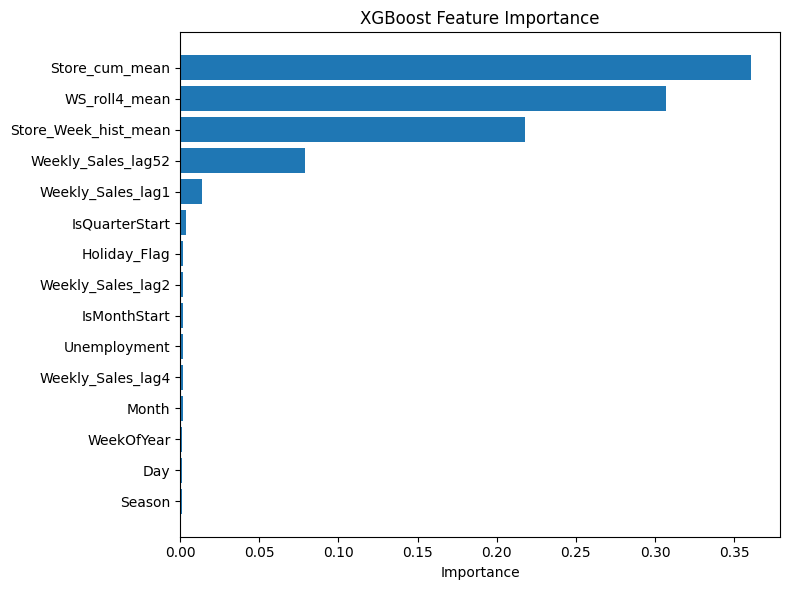

In [ ]:
def plot_feature_importance(fi_df, title, top_n=15):
    # fi_df: DataFrame with columns ["feature", "importance"]
    top = fi_df.head(top_n)

    plt.figure(figsize=(8, 6))
    plt.barh(top["feature"][::-1], top["importance"][::-1])  # reverse for nicer order
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for Random Forest
plot_feature_importance(rf_fi, "Random Forest Feature Importance", top_n=15)

# Plot for XGBoost
plot_feature_importance(xgb_fi, "XGBoost Feature Importance", top_n=15)


## SHAP анализ

### Install SHAP

In [ ]:
pip install shap

In [ ]:
import shap

# Initialize JS visualization for Jupyter
shap.initjs()


### Глобальный SHAP

Create TreeExplainer and calculate SHAP values (global sample)

In [ ]:
# Select a subset of X_test for SHAP (to speed up)
n_samples = min(1000, len(X_test))

# Use a fixed random_state for reproducibility
X_sample = X_test.sample(n_samples, random_state=42)

# Create a TreeExplainer for the trained XGBoost model
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the sample
# For regression: shap_values has shape (n_samples, n_features)
shap_values = explainer.shap_values(X_sample)

# Optional: check shapes
print("X_sample shape:", X_sample.shape)
print("shap_values shape:", shap_values.shape)

X_sample shape: (744, 25)
shap_values shape: (744, 25)


#### SHAP summary bar plot (Global feature importance based on mean(|SHAP value|) )

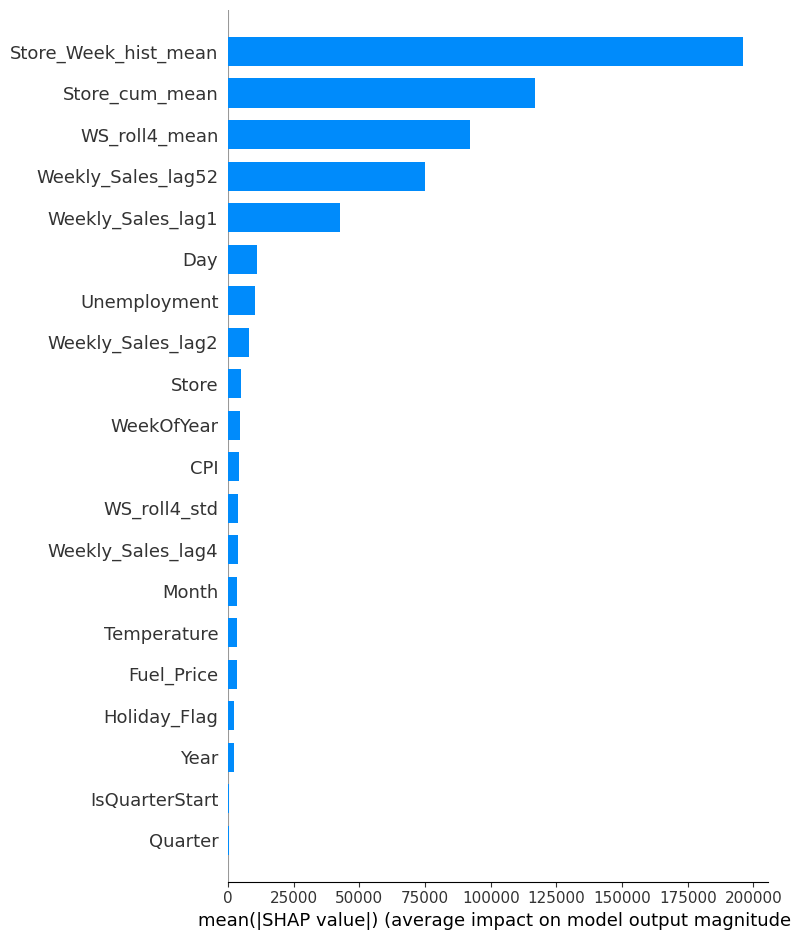

In [ ]:
# Global feature importance based on mean(|SHP value|)
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    show=True
)

#### SHAP beeswarm plot: shows both importance and direction of effect

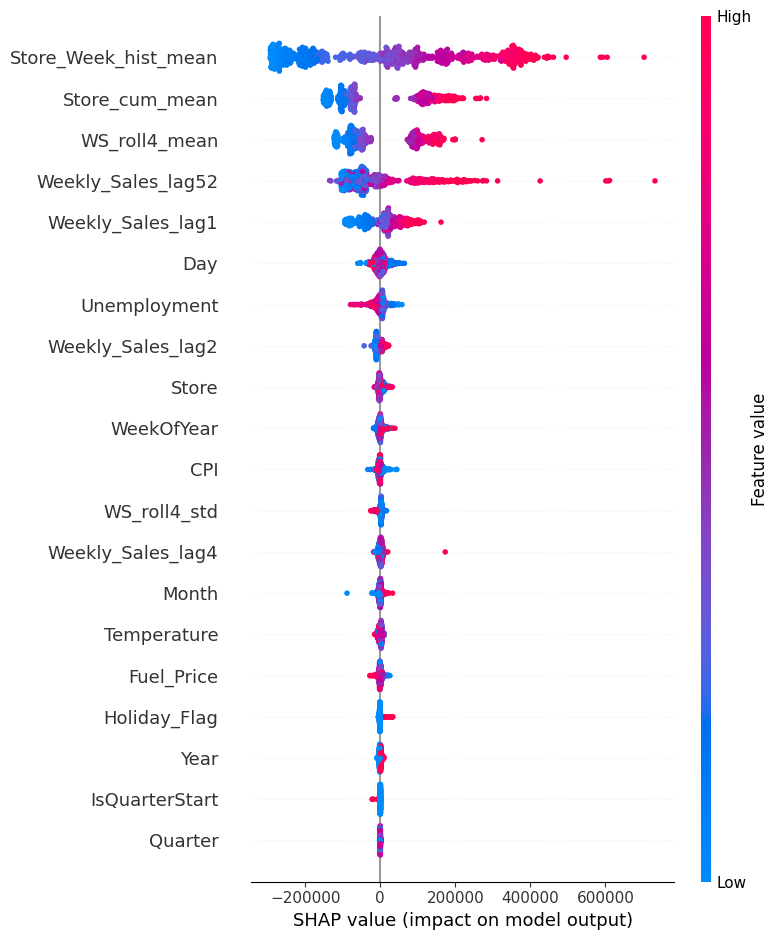

In [ ]:
# Beeswarm plot: shows both importance and direction of effect
shap.summary_plot(
    shap_values,
    X_sample,
    show=True
)


* **Главные признаки:** `Store_Week_hist_mean`, `Store_cum_mean`, `WS_roll4_mean`, `Weekly_Sales_lag52` — они дают самый большой вклад в прогноз.
* **Высокие значения** этих признаков (красные точки справа) **увеличивают прогноз продаж**.
* **Низкие значения** (синие точки слева) обычно **уменьшают прогноз**.
* Лаги `Weekly_Sales_lag1/2/4` и макро-факторы (`Unemployment`, `CPI`, `Fuel_Price`) имеют меньший разброс SHAP → их влияние слабее.
* Календарные признаки (`Month`, `Year`, `Holiday_Flag`, `IsQuarterStart`, `Quarter`) почти не меняют выход модели — точки близко к нулю.


### Локальный SHAP

Выбрать первый из X_sample

#### Waterfall plot

Пример 1: неделя с низкими прогнозируемыми продажами

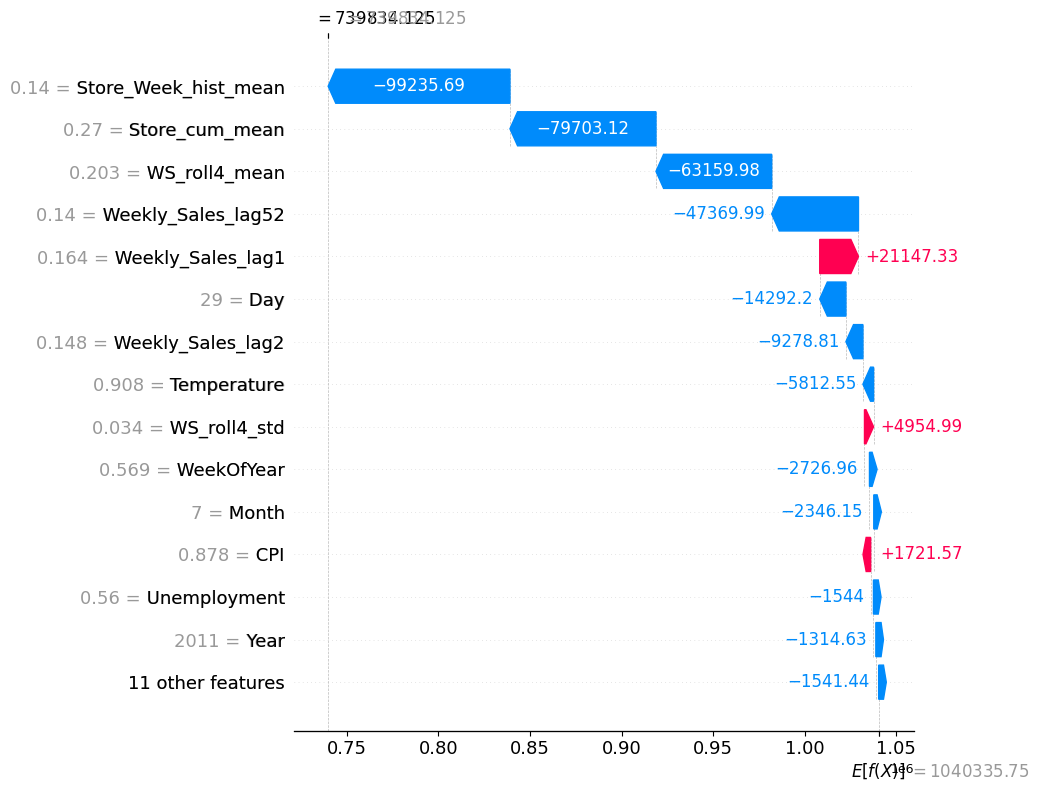

In [ ]:
# Pick one observation from X_sample for local explanation
i = 5  # index inside X_sample (you can change it)
x_i = X_sample.iloc[i, :]
shap_values_i = shap_values[i]

# Try to use the newer waterfall plot API
try:
    explanation_i = shap.Explanation(
        values=shap_values_i,
        base_values=explainer.expected_value,
        data=x_i.values,
        feature_names=X_sample.columns
    )

    # Waterfall plot for a single prediction
    shap.plots.waterfall(explanation_i, max_display=15)
except Exception as e:
    print("Waterfall plot failed, error:", e)

Смотрим на этот график, узнали причины снижения продажа:

* Базовый уровень модели (средний прогноз) справа ≈ **1.04 млн**, итоговый прогноз для этой недели ≈ **0.74 млн** → продажи ожидаются **ниже обычного**.
* Большие синие блоки слева (`Store_Week_hist_mean`, `Store_cum_mean`, `WS_roll4_mean`, `Weekly_Sales_lag52`) **сильно уменьшают прогноз**. Значит, в прошлые годы и недели этот магазин продавал мало.
* Небольшие розовые блоки (`Weekly_Sales_lag1`, `WS_roll4_std`, `CPI`) чуть **повышают прогноз**, но не могут компенсировать отрицательное влияние истории.
* Остальные признаки дают очень маленький вклад и почти не меняют результат.


Пример 2: неделя с высокими прогнозируемыми продажами

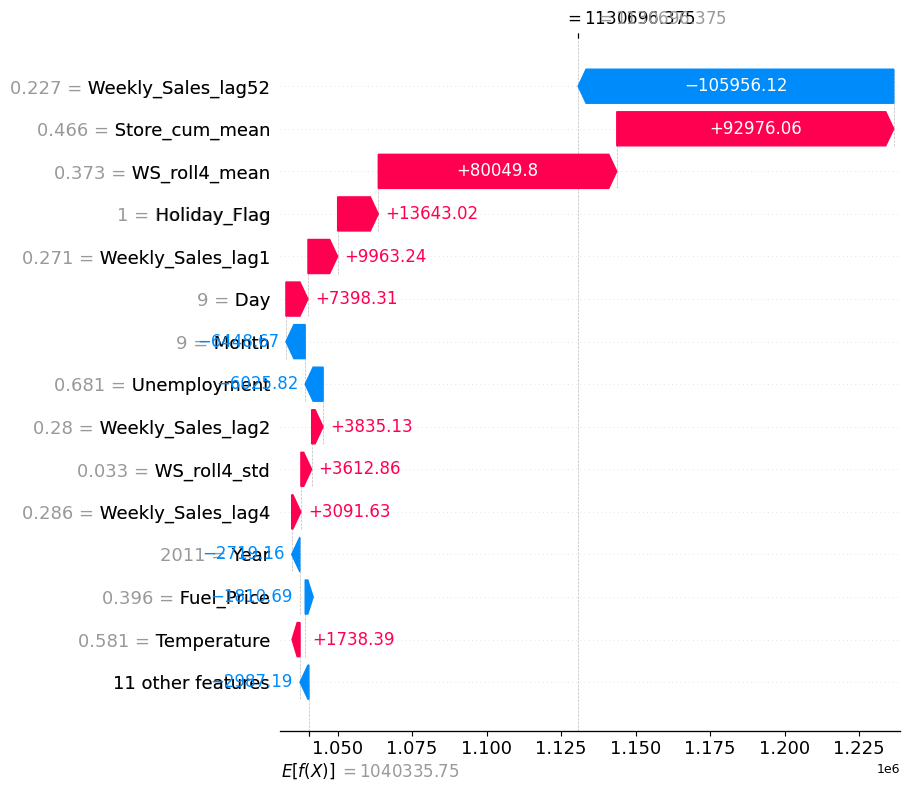

In [ ]:
# Pick one observation from X_sample for local explanation
i = 10  # index inside X_sample (you can change it)
x_i = X_sample.iloc[i, :]
shap_values_i = shap_values[i]

# Try to use the newer waterfall plot API
try:
    explanation_i = shap.Explanation(
        values=shap_values_i,
        base_values=explainer.expected_value,
        data=x_i.values,
        feature_names=X_sample.columns
    )

    # Waterfall plot for a single prediction
    shap.plots.waterfall(explanation_i, max_display=15)
except Exception as e:
    print("Waterfall plot failed, error:", e)


* Базовый уровень модели ≈ **1.04 млн**, итоговый прогноз ≈ **1.13 млн** → модель ждёт **продажи выше среднего**.
* Главные положительные факторы:

  * **Store_cum_mean** и **WS_roll4_mean** (красные большие блоки) сильно **поднимают прогноз** → у магазина в целом и в последние недели продажи были высокими.
  * **Holiday_Flag = 1** и высокий **Weekly_Sales_lag1** тоже заметно **увеличивают прогноз** → праздничная неделя и хороший результат на прошлой неделе.
* Только **Weekly_Sales_lag52** даёт большой отрицательный вклад (синий блок) → год назад в эту же неделю продажи были низкими, но это не перекрывает сильный положительный эффект текущей истории и праздника.


## Выводы


1. Были обучены две модели: **Random Forest** и **XGBoost**.
   **XGBoost** показывает немного лучшее качество (меньше MAE/RMSE, выше R²), поэтому его можно считать основной моделью.

2. И feature importance, и SHAP показывают одно и то же:
   **главные признаки** — это история продаж магазина и сезонность:
   `Store_cum_mean`, `WS_roll4_mean`, `Store_Week_hist_mean`, `Weekly_Sales_lag52`, `Weekly_Sales_lag1`.

3. Макроэкономические и календарные признаки
   (`Unemployment`, `CPI`, `Fuel_Price`, `Holiday_Flag`, `Month`, `Year`, `IsMonthStart`, `IsQuarterStart`)
   дают **очень маленький вклад**. Основная информация уже содержится в исторических признаках.

4. **Глобальный SHAP** подтверждает, что высокие значения исторических признаков **повышают прогноз продаж**, а низкие — **снижают его**.

5. **Локальный SHAP (waterfall-графики)** показывает, что:

   * при низких продажах история и сезонность тянут прогноз вниз;
   * при высоких продажах — те же признаки (и праздник) тянут прогноз вверх.
     Это делает модель понятной и пригодной для объяснения конкретных недель.
